In [3]:
from matplotlib import pyplot as plt
import numpy as np

## notes

In [ ]:
def load_theory_result(path):

    return data


def normalize(radial_profile, rng=(50, 340)):
    div = radial_profile[...,rng[0]:rng[1]].sum(-1)[...,None]
    return radial_profile / ( div + 1e-16)

In [10]:
experimental_data = np.loadtxt("../csvs/water_Iq_v_time.csv", delimiter=',')
print(experimental_data.shape)
time_delays = [10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,110.0]

(500, 12)


NameError: name 'ds_name' is not defined

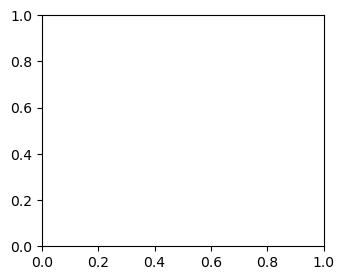

In [4]:
# RP vs Delay Time

# --- plotting
plt.figure(figsize=(8,3))

plt.subplot(111)
plt.title("")

plt.plot(experimental_data[:,0], experimental_data[:,1] color='k')

for i,b in enumerate(time_delays):
    
    rp = normalize(rp_means[i,:,:].mean(0)) # avg powers
    
    plt.plot(d['radial_profile_qvalues'], rp,
             color=cm.winter(b/time_delays.max()))

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
plt.xlim([0.3, 2.5])
plt.ylim([0.0, 0.007])

plt.vlines([d['radial_profile_qvalues'][new_peak_pos],
            d['radial_profile_qvalues'][wat_peak_pos]], 
           0.0, 0.007, lw=0.5)

plt.legend(['no pump'] + ['%d fs' % b for b in time_delays], 
           prop={'size': 7}, ncol=2, framealpha=1.0)

plt.tight_layout()
plt.show()


# write a CSV for export to collaborators
csv_data = np.array(csv_data).T # column-major
header = '# q/A,' + 'fs,'.join([ str(x) for x in time_delays ]) + '\n'
np.savetxt('csvs/%s_Iq_v_time.csv' % ds_name, csv_data, header=header, delimiter=',', fmt='%.8f')